# Overlay plot generation

These code cells step through the process of making the final overlay plot, shown as Figure 9 in Gauld et al. (2026)

In [1]:

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import glob
import pandas as pd

In [2]:
M3ID_USE = 'M3G20090212T082712'
LH_USE = 8

prefix_path = '../'

LOLA_PATH = glob.glob(f'{prefix_path}Results/Worked/{M3ID_USE}/*hillshade*')[0]
RDN_PATH = glob.glob(f'{prefix_path}Results/Worked/{M3ID_USE}/*RDN_NORM*')[0]
THERM_PATH = f"{prefix_path}Data_Thermal/TIFFs/{M3ID_USE}/{M3ID_USE}_localhour_{LH_USE}.tif"

RDN_LOLA_H_PATH = glob.glob(f'{prefix_path}Results/Worked/{M3ID_USE}/*HOMOGRAPHY*')[0]
THERM_RDN_H_PATH = glob.glob(f'{prefix_path}Results/Thermal/{M3ID_USE}/Worked/*localhour_{LH_USE}*HOMOGRAPHY*')[0]

info_dat = pd.read_csv(f"{prefix_path}Results/dataout.csv")

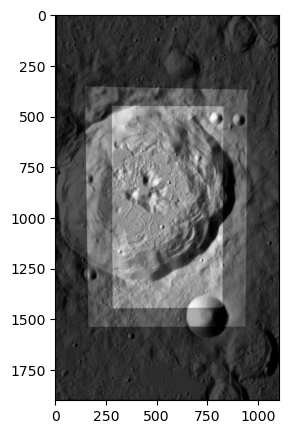

In [3]:
LOLA  = cv.imread(LOLA_PATH, cv.IMREAD_UNCHANGED)
RDN   = cv.imread(RDN_PATH,  cv.IMREAD_UNCHANGED)
THERM = cv.imread(THERM_PATH,cv.IMREAD_UNCHANGED)

SCALE_FACTOR = 140/60 # Scale to 140 m/pix to match M3

R_H = int(round(0.95* RDN.shape[0] * SCALE_FACTOR))
R_W = int(round(0.8* RDN.shape[1] * SCALE_FACTOR))

# In matching the thermal image, it is cropped, but the input image is the
# entire thermal scene-crop to match the region defined in FeatureMatch_Thermal.py
T_CY, T_CX = THERM.shape[0]//2, THERM.shape[1]//2

y0 = T_CY - R_H // 2
y1 = y0 + R_H

x0 = T_CX - R_W // 2
x1 = x0 + R_W

THERM_CROPPED = np.zeros_like(THERM)
THERM_CROPPED[y0:y1, x0:x1] = THERM[y0:y1, x0:x1]

# Homography to map RDN onto LOLA
H_RDN_LOLA = np.loadtxt(RDN_LOLA_H_PATH, delimiter=",").astype(float) 
# Homography to map THERM onto RDN
H_THERM_RDN = np.loadtxt(THERM_RDN_H_PATH, delimiter=",").astype(float) 
# Chain homographies to map THERM onto LOLA
H_THERM_LOLA = H_RDN_LOLA@H_THERM_RDN

# Apply homographies to match transforms
RDN_IN_LOLA = cv.warpPerspective(
    RDN, H_RDN_LOLA, LOLA.shape[::-1],
)
THERM_IN_RDN = cv.warpPerspective(
    THERM_CROPPED, H_THERM_RDN, RDN.shape[::-1],
)
THERM_IN_LOLA = cv.warpPerspective(
    THERM_CROPPED, H_THERM_LOLA, LOLA.shape[::-1],
)

# Blended output
TOTAL_OVERLAY = (THERM_IN_LOLA)//3 + RDN_IN_LOLA//3 + LOLA//3

# Quick look at total overlay image
plt.figure(figsize=(5,5))
plt.imshow(TOTAL_OVERLAY, cmap='gray')

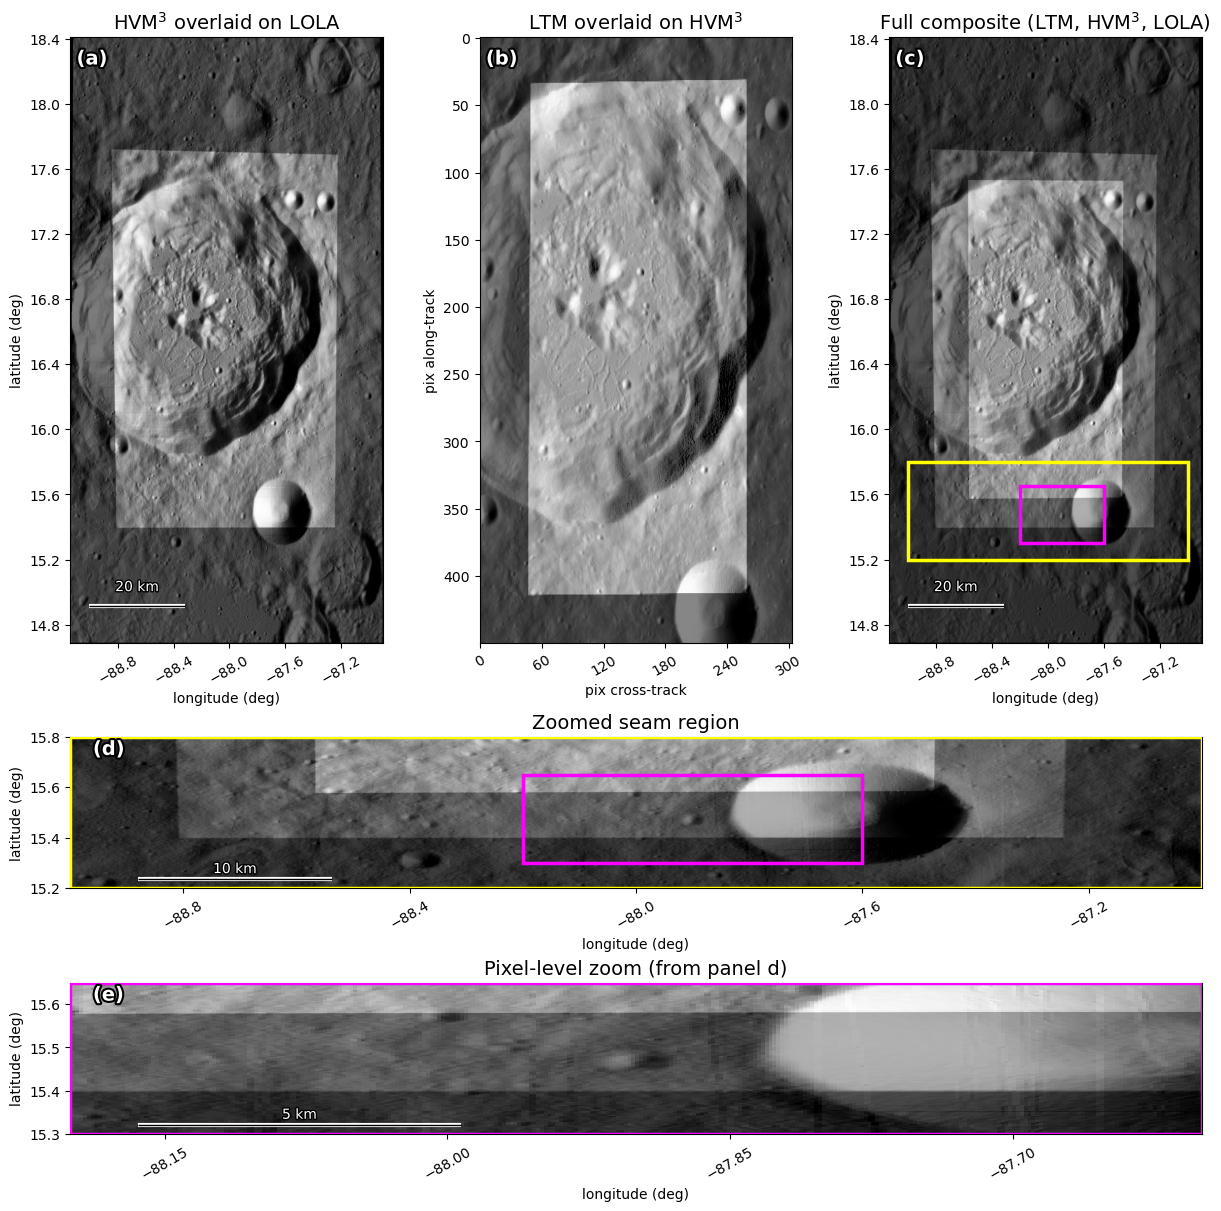

In [4]:
MOON_R_M = 1_737_400.0
DEG2RAD = np.pi / 180.0
tsize = 14

def add_panel_label(ax, label, x=0.02, y=0.98):
    ax.text(
        x, y, label,
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=tsize, fontweight="bold", color="white",
        path_effects=[pe.withStroke(linewidth=3, foreground="black")],
        zorder=50
    )

def add_moon_scalebar(ax, desired_frac=0.25, candidates_km=(5, 10, 20, 50, 100, 200), pad_frac=0.05, label=None):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    phi_mid = 0.5 * (ymin + ymax)
    m_per_deg_lon = DEG2RAD * MOON_R_M * max(np.cos(phi_mid * DEG2RAD), 1e-8)

    width_deg = abs(xmax - xmin)
    width_m = width_deg * m_per_deg_lon
    target_m = desired_frac * width_m

    bar_km = min(candidates_km, key=lambda k: abs(k * 1000 - target_m))
    bar_m = bar_km * 1000.0
    bar_deg = bar_m / m_per_deg_lon

    xpad = pad_frac * (xmax - xmin)
    ypad = pad_frac * (ymax - ymin)
    x0 = xmin + xpad
    y0 = ymin + ypad

    ax.plot([x0, x0 + bar_deg], [y0, y0], color="white", lw=3, solid_capstyle="butt", zorder=10)
    ax.plot([x0, x0 + bar_deg], [y0, y0], color="black", lw=1, solid_capstyle="butt", zorder=11)

    text = f"{bar_km} km" if label is None else label
    ax.text(
        x0 + bar_deg / 2.0, y0 + 0.02 * (ymax - ymin),
        text, ha="center", va="bottom", fontsize=tsize - 4, color="white",
        path_effects=[pe.withStroke(linewidth=2, foreground="black")], zorder=12
    )

def crop_image_by_lonlat(img, extent, lon0, lon1, lat0, lat1):
    """
    Crop a lon/lat-extent image array to a lon/lat box.
    Assumes imshow default origin='upper' (row 0 is latmax).
    extent = [lonmin, lonmax, latmin, latmax]
    """
    lonmin, lonmax, latmin, latmax = extent
    nrows, ncols = img.shape[:2]

    # Convert lon/lat to fractional pixel indices
    x0 = (lon0 - lonmin) / (lonmax - lonmin) * (ncols - 1)
    x1 = (lon1 - lonmin) / (lonmax - lonmin) * (ncols - 1)

    # For y: row 0 corresponds to latmax when origin='upper'
    y0 = (latmax - lat1) / (latmax - latmin) * (nrows - 1)  # lat1 is upper of box
    y1 = (latmax - lat0) / (latmax - latmin) * (nrows - 1)  # lat0 is lower of box

    c0, c1 = int(np.floor(min(x0, x1))), int(np.ceil(max(x0, x1)))
    r0, r1 = int(np.floor(min(y0, y1))), int(np.ceil(max(y0, y1)))

    # Clip to bounds
    c0 = max(c0, 0); c1 = min(c1, ncols - 1)
    r0 = max(r0, 0); r1 = min(r1, nrows - 1)

    sub = img[r0:r1+1, c0:c1+1]

    # New extent from pixel bounds
    lon0_new = lonmin + (c0 / (ncols - 1)) * (lonmax - lonmin)
    lon1_new = lonmin + (c1 / (ncols - 1)) * (lonmax - lonmin)
    lat1_new = latmax - (r0 / (nrows - 1)) * (latmax - latmin)
    lat0_new = latmax - (r1 / (nrows - 1)) * (latmax - latmin)

    return sub, [lon0_new, lon1_new, lat0_new, lat1_new]

# ----------------- your data load -----------------

m3id=M3ID_USE
LOLA_HVM3 = RDN_IN_LOLA//2 + LOLA//2
HVM3_LTM = THERM_IN_RDN//2 + RDN//2
FULL_COMPOSITE = TOTAL_OVERLAY

row_dict = (
    info_dat.loc[info_dat["M3ID"] == M3ID_USE]
    .iloc[0]
    .to_dict()
)

FULL_EXTENT = [row_dict['BND_LON_MIN'], 
               row_dict['BND_LON_MAX'], 
               row_dict['BND_LAT_MIN'], 
               row_dict['BND_LAT_MAX'], ]

# ----------------- zoom definitions -----------------
# (d): your current seam zoom
D_LON0, D_LON1 = -89, -87 #-118.8, -117.9
D_LAT0, D_LAT1 = 15.2, 15.8  #3.6, 4.8

# (e): pick a smaller box inside (d) near the landform you want to show at pixel level
# IMPORTANT: update these to the landform you want (tight box!)
E_LON0, E_LON1 = -88.2, -87.6 #-118.36, -118.15
E_LAT0, E_LAT1 = 15.3, 15.65 #3.75, 4.35

# Crop the FULL_COMPOSITE array for (e) so we are actually showing pixels at native resolution
FULL_E, EXTENT_E = crop_image_by_lonlat(FULL_COMPOSITE, FULL_EXTENT, E_LON0, E_LON1, E_LAT0, E_LAT1)

# ----------------- figure layout -----------------
fig = plt.figure(figsize=(12, 12), layout="constrained")
gs = GridSpec(5, 3, figure=fig, height_ratios=[1, 1, 1, 0.75, 0.75])

ax1 = fig.add_subplot(gs[0:3, 0])
ax2 = fig.add_subplot(gs[0:3, 1])
ax3 = fig.add_subplot(gs[0:3, 2])
ax4 = fig.add_subplot(gs[3, :])
ax5 = fig.add_subplot(gs[4, :])

# (a)
ax1.imshow(LOLA_HVM3, cmap="gray", extent=FULL_EXTENT, aspect="auto")
ax1.set_title("HVM$^3$ overlaid on LOLA", fontsize=tsize)
add_panel_label(ax1, "(a)")

# (b)
ax2.imshow(HVM3_LTM, cmap="gray", aspect="auto")
ax2.set_title("LTM overlaid on HVM$^3$", fontsize=tsize)
add_panel_label(ax2, "(b)")

# (c)
ax3.imshow(FULL_COMPOSITE, cmap="gray", extent=FULL_EXTENT, aspect="auto")
ax3.set_title("Full composite (LTM, HVM$^3$, LOLA)", fontsize=tsize)
add_panel_label(ax3, "(c)")

# (d) seam zoom
ax4.imshow(FULL_COMPOSITE, cmap="gray", extent=FULL_EXTENT, aspect="auto")
ax4.set_xlim(D_LON0, D_LON1)
ax4.set_ylim(D_LAT0, D_LAT1)
ax4.set_title("Zoomed seam region", fontsize=tsize)
add_panel_label(ax4, "(d)")

# (e) pixel-level zoom into (d)
ax5.imshow(FULL_E, cmap="gray", extent=EXTENT_E, aspect="auto", interpolation="none")
ax5.set_xlim(E_LON0, E_LON1)
ax5.set_ylim(E_LAT0, E_LAT1)
ax5.set_title("Pixel-level zoom (from panel d)", fontsize=tsize)
add_panel_label(ax5, "(e)")

# rectangles: (c) shows (d) region
rect_d_on_c = patches.Rectangle(
    (D_LON0, D_LAT0), D_LON1 - D_LON0, D_LAT1 - D_LAT0,
    linewidth=2.5, edgecolor="yellow", facecolor="none", zorder=20
)
ax3.add_patch(rect_d_on_c)
rect_d_on_c2 = patches.Rectangle(
    (D_LON0, D_LAT0), D_LON1 - D_LON0, D_LAT1 - D_LAT0,
    linewidth=2.5, edgecolor="yellow", facecolor="none", zorder=20
)
ax4.add_patch(rect_d_on_c2)

# rectangles: (d) shows (e) region
rect_e_on_d = patches.Rectangle(
    (E_LON0, E_LAT0), E_LON1 - E_LON0, E_LAT1 - E_LAT0,
    linewidth=2.5, edgecolor="magenta", facecolor="none", zorder=20
)
ax4.add_patch(rect_e_on_d)
rect_e_on_d2 = patches.Rectangle(
    (E_LON0, E_LAT0), E_LON1 - E_LON0, E_LAT1 - E_LAT0,
    linewidth=2.5, edgecolor="magenta", facecolor="none", zorder=20
)
ax5.add_patch(rect_e_on_d2)
rect_e_on_d0 = patches.Rectangle(
    (E_LON0, E_LAT0), E_LON1 - E_LON0, E_LAT1 - E_LAT0,
    linewidth=2.5, edgecolor="magenta", facecolor="none", zorder=20
)
ax3.add_patch(rect_e_on_d0)

# scale bars on lon/lat axes
for ax in (ax1, ax3, ax4, ax5):
    add_moon_scalebar(ax, desired_frac=0.25, candidates_km=(1, 2, 5, 10, 20, 50, 100), pad_frac=0.06)

# axis formatting
for ax in (ax1, ax3, ax4, ax5):
    ax.set_xlabel("longitude (deg)", fontsize=tsize - 4)
    ax.set_ylabel("latitude (deg)", fontsize=tsize - 4)
    ax.tick_params(axis="x", labelrotation=30)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))

ax2.set_xlabel("pix cross-track", fontsize=tsize - 4)
ax2.set_ylabel("pix along-track", fontsize=tsize - 4)
ax2.tick_params(axis="x", labelrotation=30)
ax2.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax2.yaxis.set_major_locator(MaxNLocator(nbins=10))

# tighten tick density on (d)/(e) if you want
ax4.yaxis.set_major_locator(MaxNLocator(nbins=4))
ax5.yaxis.set_major_locator(MaxNLocator(nbins=4))

# Uncomment to save the figure as a png
# plt.savefig("fig9.png", transparent=True, dpi=300, bbox_inches="tight")
